# Marrakech MCTS

Notebook pour les expériences.

Liens :

- cours : https://www.lamsade.dauphine.fr/~cazenave/MonteCarlo.pdf

- Modélisation : https://github.com/sor8sh/Marrakech/blob/main/main.py
- Idee diff de MCTS : https://github.com/IraSkyx/marrakech-ai
- https://github.com/bubka42/marrakech
- MCTS for stochastic games : https://www.lamsade.dauphine.fr/~cazenave/papers/mctrsg.pdf


In [1]:
from pickle import NEWOBJ_EX
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from itertools import cycle, count
import random 
import copy
from tqdm import tqdm
import math
import time
import random
from collections import defaultdict
import pandas as pd
from itertools import combinations
import plotly.express as px
import plotly.graph_objects as go
import pickle
import seaborn as sns

In [15]:
def save_pickle(doc, filename):
    with open(f'./results/{filename}.pkl', 'wb') as handle:
        pickle.dump(doc, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(filename):
    with open(f'./results/{filename}.pkl', 'rb') as handle:
         doc = pickle.load(handle)
    return doc

# 1 - Implémentation du jeu

In [2]:
###########################
# --- GLOBAL VARIABLES ---
###########################

random.seed(42)

BOARD_SIZE=5
N_RUGS=8
MIDDLE=2
DICE=[1,2,2,3]

# Colors of the rugs
EMPTY = 0
RED = 1 #player 1
BLUE = 2 #player 2
PINK = 3 #player 1
GREEN = 4 #player 2


colors = [RED, BLUE, PINK, GREEN]
color_cycle = cycle(colors)
#next(color_cycle) gives the next color to play

# Counters for each color to increment when instanciating new Rug, starts at 1
red_counter = count(1)
blue_counter = count(1)
pink_counter = count(1)
green_counter = count(1)

# Orientations of the pawn
NORTH = (0, 1)
SOUTH = (0, -1)
EAST = (1, 0)
WEST = (-1, 0)

orientations_int2str = {NORTH: "north", SOUTH: "south", EAST: "east", WEST: "west"}
colors_int2str = {RED: "red", BLUE: "blue", PINK: "pink", GREEN: "green"}

# U turns (demi tour) of the pawn
u_turn = {
    NORTH: SOUTH,
    SOUTH: NORTH,
    EAST: WEST,
    WEST: EAST,
}

####################
# --- FUNCTIONS ---
####################

def adjacent_coord(coord):
    """Returns all squares' coordinates (x', y') adjacent to square of coordinate `coord` (x, y)

    Args:
        coord (tuple of int): coordinate (x,y) of the square of interest

    Returns:
        list of tuples: list of adjacent positions
    """
    x, y = coord
    answer = []
    if -1 < x - 1 < BOARD_SIZE:
        answer.append((x - 1, y))
    if -1 < x + 1 < BOARD_SIZE:
        answer.append((x + 1, y))
    if -1 < y - 1 < BOARD_SIZE:
        answer.append((x, y - 1))
    if -1 < y + 1 < BOARD_SIZE:
        answer.append((x, y + 1))
    return answer

def next_color(color):
    '''
    Permet de trouver la couleur du tapis suivant à poser.
    '''
    next = ''
    if color == RED:
        next = BLUE
    elif color == BLUE:
        next = PINK
    elif color == PINK:
        next = GREEN
    elif color == GREEN:
        next = RED

    if next == '':
        print('The color is incorrect')

    return next
  

##################
# --- CLASSES ---
##################

class Position(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return f'({self.x},{self.y})'

    def get_coord(self):
        return self.x, self.y

    def is_out_of_board(self, board_limit):
        """Check if the position of coordinates (x,y) is outside the board.
        
        Args:
            board_limit (int): board limit in terms of indices 
                               (e.g. if board is of size 7, then board_limit = 6)
        """

        if self.x < 0 or self.x > board_limit or self.y < 0 or self.y > board_limit:
            return True
        return False


class Rug(object):

    def __init__(self, color, sq1_pos, sq2_pos, incr=False):
        self.color = color
        self.sq1_pos = Position(sq1_pos[0], sq1_pos[1]) 
        self.sq2_pos = Position(sq2_pos[0], sq2_pos[1])
        if incr:
            self.id = self.increment_id()
        else:
            self.id = 0

    def __str__(self):
        return f"Rug {colors_int2str[self.color]} of id {self.id} at position ({self.sq1_pos}, {self.sq2_pos})."

    def increment_id(self):
        if self.color == RED:
            return next(red_counter)
        if self.color == BLUE:
            return next(blue_counter)
        if self.color == PINK:
            return next(pink_counter)
        if self.color == GREEN:
            return next(green_counter)

    def create_real(self, incr=True):
        rug_copy = Rug(self.color, self.sq1_pos.get_coord(), self.sq2_pos.get_coord(), incr)
        return rug_copy

class Pawn(object):
    def __init__(self):
        # The pawn start at the center of the board
        self.position = Position(MIDDLE, MIDDLE)
        self.orientation = NORTH

    def __str__(self):
        result = f'({self.position}, {orientations_int2str[self.orientation]})'
        return result
    
    def set_position(self, x, y):
        self.position.x = x
        self.position.y = y

    def set_orientation(self, orientation):
        self.orientation = orientation

    def legal_orientations(self):
        # The pawn cannot make a u turn
        orientations = [NORTH, SOUTH, EAST, WEST]
        orientations.remove(u_turn[self.orientation])
        return orientations

    def legal_move(self, new_orientation, dice):

        #   Case 1: pawn does not go out from the board
        legal_x = self.position.x + new_orientation[0] * dice
        legal_y = self.position.y + new_orientation[1] * dice
        legal_position = Position(legal_x, legal_y)

        #   Case 2: pawn goes out from the board (implementation brute-force)
        if legal_position.is_out_of_board(board_limit=(BOARD_SIZE-1)): 
            # Count the number of steps left after moving out of the board
            # Place the pawn at the limit of the board
            if new_orientation == NORTH:
                steps_left = legal_y - (BOARD_SIZE-1)
                legal_y = (BOARD_SIZE-1)
            elif new_orientation == EAST:
                steps_left = legal_x - (BOARD_SIZE-1)
                legal_x = (BOARD_SIZE-1)
            elif new_orientation == SOUTH:
                steps_left = -legal_y
                legal_y = 0
            elif new_orientation == WEST:
                steps_left = -legal_x
                legal_x = 0

            # Place the pawn after it has moved out from the board 
            # It counts as a step
            new_orientation, legal_x, legal_y = self.get_move_in_board(new_orientation, legal_x, legal_y)
            steps_left = steps_left - 1
            
            # Move the pawn according to the number of steps left
            legal_x = legal_x + new_orientation[0] * steps_left
            legal_y = legal_y + new_orientation[1] * steps_left
        
        return new_orientation, legal_x, legal_y

    def get_move_in_board(self, orientation, x, y):
        """Get the new orientation and coordinates (new_x, new_y) of the pawn after moving out of the board."""
        # Bottom left corner (0,0)
        if (x, y) == (0,0) and orientation == SOUTH:
            orientation = EAST
        elif (x, y) == (0,0) and orientation == WEST:
            orientation = NORTH
        # Top right corner (6,6)
        elif (x, y) == ((BOARD_SIZE-1),(BOARD_SIZE-1)) and orientation == EAST:
            orientation = SOUTH
        elif (x, y) == ((BOARD_SIZE-1),(BOARD_SIZE-1)) and orientation == NORTH:
            orientation = WEST
        # Bottom side (y = 0)
        elif orientation == SOUTH:
            x = x + 1 if x % 2 == 1 else x - 1
            orientation = NORTH
        # Right side (x = 6)
        elif orientation == EAST:
            y = y + 1 if y % 2 == 0 else y - 1
            orientation = WEST
        # Top side (y = 6)
        elif orientation == NORTH:
            x = x + 1 if x % 2 == 0 else x - 1
            orientation = SOUTH
        # Left side (x = 0)
        elif orientation == WEST:
            y = y + 1 if y % 2 == 1 else y - 1
            orientation = EAST
        return orientation, x, y

    def move(self, new_orientation, new_x, new_y):
        self.set_orientation(new_orientation)
        self.set_position(new_x, new_y)

    def get_nb_same_color_squares(self, board):
        """Compute the number of adjacents squares of the same color
        as the square's color on which the pawn is"""
        counter = 1 # Init to 1 because the initial square counts
        pawn_x, pawn_y = self.position.get_coord()
        pawn_color = board.get_color(pawn_x, pawn_y)

        coords_to_check = adjacent_coord((pawn_x, pawn_y))
        visited_coords = set((pawn_x, pawn_y))
        while coords_to_check:
            x, y = coords_to_check.pop(0)
            visited_coords.add((x, y))
            color = board.get_color(x, y)
            if color == pawn_color:
                counter += 1
                adj_coords = adjacent_coord((x,y))
                # Only append to coords_to_check not visited coords yet and of same color as the pawn
                for coord in adj_coords:
                    if coord not in visited_coords:
                        coords_to_check.append(coord)
        return counter

  
class Player(object):
    def __init__(self, id, colors):
        self.id = id
        self.colors = colors
        self.rugs_left = 2*N_RUGS
        self.coins = 30
    
    def pay(self, amount, opponent_player):
        #If the player doesn't have enough money
        if self.coins - amount < 0:
            opponent_player.coins += self.coins
            self.coins = 0
        #If the player can pay
        else:
            self.coins -= amount
            opponent_player.coins += amount

    def score(self, board):
        # Sum of coins and the number of squares of the player's colors
        s = self.coins
        for x in range(board.size):
            for y in range(board.size):
                if board.board[x,y][0] in self.colors:
                    s += 1
        return s
  
class Move(object):
    def __init__(self, pawn, new_orientation, new_x, new_y, rug, dice):
        self.pawn = pawn
        self.new_orientation = new_orientation
        self.new_x = new_x
        self.new_y = new_y
        self.rug = rug
        self.dice = dice
        
    def __str__(self):
        
        if self.pawn.orientation == self.new_orientation:
            assam = f'The pawn stays in his orientation ({orientations_int2str[self.pawn.orientation]}).\n'
        else:
            assam = f'The pawn is reoriented from {orientations_int2str[self.pawn.orientation]} to {orientations_int2str[self.new_orientation]}.\n'
        assam_move = f'Assam is moving from {self.pawn.position.__str__()} to ({self.new_x},{self.new_y}).\n'
        tapis = f"A rug of color {colors_int2str[self.rug.color]} (id={self.rug.id}) is placed at ({self.rug.sq1_pos}, {self.rug.sq2_pos})."
        result = assam + assam_move + tapis
        return result
        
        #result = f'({orientations_int2str[self.new_orientation]}, ({self.new_x, self.new_y}), {self.rug})'
        #return result 

    def is_pawn_new_orientation_valid(self):
        # It is valid if no u-turn
        return self.new_orientation in self.pawn.legal_orientations()

    def is_pawn_new_position_valid(self):
        
        return True

    def is_rug_adjacent_to_pawn(self):
        # Check if adjacent to pawn and also not on the pawn's position

        # List of all valid coordinates around the pawn
        x, y = self.new_x, self.new_y
        init_valid_coord = adjacent_coord((x, y))
        valid_coord = init_valid_coord.copy()
        for coord in init_valid_coord:
            valid_coord.extend(adjacent_coord(coord))
        set_valid_coord = set(valid_coord)
        set_valid_coord.remove((x, y))

        # Check if the rug's both squares are in the set
        if self.rug.sq1_pos.get_coord() and self.rug.sq2_pos.get_coord() in set_valid_coord:
            return True
        return False

    def is_rug_covering_another_rug(self, board):
        # Rug's new placement is valid if it doesn't cover another rug
        # We need to check if the both squares are covered by the same rug (same color and same id)
        sq1_color_and_id = board.board[self.rug.sq1_pos.x, self.rug.sq1_pos.y]
        sq2_color_and_id = board.board[self.rug.sq2_pos.x, self.rug.sq2_pos.y]
        if not np.array_equal(sq1_color_and_id, np.zeros(2)) and np.array_equal(sq1_color_and_id, sq2_color_and_id):
            return True
        return False

    def valid(self, board):
        #print(self.is_pawn_new_orientation_valid(), self.is_pawn_new_position_valid(), self.is_rug_adjacent_to_pawn(), self.is_rug_covering_another_rug(board)) 
        if not self.is_pawn_new_orientation_valid():
            return False
        elif not self.is_pawn_new_position_valid():
            return False
        elif not self.is_rug_adjacent_to_pawn():
            return False
        elif self.is_rug_covering_another_rug(board):
            return False
        return True

class Board(object):
    def __init__(self, size=BOARD_SIZE, verbose=False):
        self.h = 0 # Hash value
        self.size = size
        self.board = np.zeros((size, size, 2)) # Cell(x,y) = (rug_color, rug_id)
        self.pawn = Pawn() # Initialize at (3,3)
        self.players = [Player(0, [RED, PINK]), Player(1, [BLUE, GREEN])]
        self.current_player = self.players[0]
        self.current_color = RED # Start with first color of first player
        self.verbose = verbose
        self.nb_turns = 1
        self.cycle_players = cycle(self.players)

        self.hashTable = defaultdict()
        for pawn in ['assam', 'no_assam']:
            self.hashTable[pawn] = defaultdict()
            for orientation in [NORTH, SOUTH, EAST, WEST]:
                self.hashTable[pawn][orientation] = defaultdict()
                for dice_result in [1, 2, 3]:
                    self.hashTable[pawn][orientation][dice_result] = defaultdict()
                    for x in range(5):
                        self.hashTable[pawn][orientation][dice_result][x] = defaultdict()
                        for y in range(5):
                            self.hashTable[pawn][orientation][dice_result][x][y] = defaultdict()
                            for rug_color in [RED, BLUE, PINK, GREEN, EMPTY]:
                                self.hashTable[pawn][orientation][dice_result][x][y][rug_color] = random.randint(0, 2**64)
        
        self.hashTurn = random.randint(0, 2**64) # hash value for changing player
        self.hashColor = random.randint(0, 2**64) # hash value for changing rug color
        #self.transpositionTable = {}
        # (h, (total_num_playouts,
        #      list num playouts for each move,
        #      list num wins for each move))
        
        
        
        
    def __str__(self):
        #print(self.board)
        pass

    def throw_dice(self):
        dice = DICE
        return random.choice(dice)

    def get_color(self, x, y):
        """Get the color of the square (x,y)"""
        return self.board[x,y][0]

    def get_number(self, x, y):
        """Get the number of the square (x,y)"""
        return self.board[x,y][1]

    def legal_moves(self, dice):
        """Get list of legal moves among 4x49x12 possible moves.

        - Orientation (4, including 3 valid)
        - Pawn movement (49, including 1 valid according to the orientation and dice's result)
        - Rug placement (12, including ? according to the pawn and other rugs' position)

        """
        moves = [] # List of all possible valid moves

        # For every orientation
        for orientation in [NORTH, SOUTH, EAST, WEST]:
            if orientation != u_turn[self.pawn.orientation]:
                #we check where the pawn should end
                _, x, y = self.pawn.legal_move(orientation, dice)
                # For every square around the pawn
                for sq1_coord in adjacent_coord((x, y)):
                    # For every square around those squares
                    for sq2_coord in adjacent_coord(sq1_coord):
                        rug_notreal = Rug(self.current_color, sq1_coord, sq2_coord)
                        m = Move(self.pawn, orientation, x, y, rug_notreal, dice)
                        # Check if the move is legal

                        if m.valid(self):
                            # If yes, add to moves

                            moves.append(m)
        return moves

    def score(self):
        # We can think the score as player1's score - player2's score
        # Such that if it's positive, player 1 wins, if negative player 2 wins 
        player1_score = self.players[0].score(self)
        player2_score = self.players[1].score(self)
        return player1_score - player2_score

    def terminal(self):
        total = 0
        for player in self.players:
            total += player.rugs_left
        if total == 0:
            return True
        return False

    def play(self, move):
        
        move.rug = move.rug.create_real()
        if self.verbose:
          print(move.__str__())
        
        # 1. Orientate and move the pawn
        self.pawn.move(move.new_orientation, move.new_x, move.new_y)
        
        self.h = self.h ^ self.hashTable['no_assam'][self.pawn.orientation][move.dice][self.pawn.position.x][self.pawn.position.y][self.get_color(self.pawn.position.x, self.pawn.position.y)]
        self.h = self.h ^ self.hashTable['assam'][move.new_orientation][move.dice][move.new_x][move.new_y][self.get_color(move.new_x, move.new_y)]

        # 2. Place a rug
        self.board[move.rug.sq1_pos.x, move.rug.sq1_pos.y] = np.array([move.rug.color, move.rug.id])
        self.board[move.rug.sq2_pos.x, move.rug.sq2_pos.y] = np.array([move.rug.color, move.rug.id])
        self.current_player.rugs_left -= 1
        
        self.h = self.h ^ self.hashTable['no_assam'][move.new_orientation][move.dice][move.rug.sq1_pos.x][move.rug.sq1_pos.y][move.rug.color]
        self.h = self.h ^ self.hashTable['no_assam'][move.new_orientation][move.dice][move.rug.sq2_pos.x][move.rug.sq2_pos.y][move.rug.color]
        
        # 3. Pay opponent
        # Pay only if the pawn is on an opponent color
        current_square_color = self.get_color(self.pawn.position.x, self.pawn.position.y)
        opponent_player_id = abs(self.current_player.id - 1)
        if self.verbose:
            if current_square_color:
                print(f'The players ends on a {colors_int2str[current_square_color]} rug.')
            else:
                print(f'The player ends on an empty case.')
        #very important : the player only have to pay if he is on an opponent rug ! not if it is an empty case !
        if current_square_color:
            if current_square_color not in self.current_player.colors:
                amount = self.pawn.get_nb_same_color_squares(self)
                if self.verbose:
                    print(f'This rug belongs to player {self.players[opponent_player_id].id}.')
                    print(f'The current player has to give him {amount} coins.')
                self.current_player.pay(amount, self.players[opponent_player_id])
            else:
                if self.verbose:
                    print("The rug is his so he doesn't have to pay.")
        if self.verbose:
            print(f'Player {self.players[0].id} has {self.players[0].coins} coins. Player {self.players[1].id} has {self.players[1].coins}.')
          
        # Change turn
        self.current_player = self.players[opponent_player_id]
        #self.current_payer = next(self.cycle_players)
        self.current_color = next_color(self.current_color)
        
        self.h = self.h ^ self.hashTurn 
        self.h = self.h ^ self.hashColor

    def playout(self):
        """Play a random game from the current state.
        Returns the result of the random game."""

        while(True):
            # Throw the dice for the current player
            dice_result = self.throw_dice()
            #We get all the legal moves for this dice result
            moves = self.legal_moves(dice=dice_result)
            # If the game is over
            if self.terminal():
                # Victory for player 1
                if self.score() < 0:
                    if self.verbose:
                        print("Player 1 wins !!!")
                    return -1
                # Victory for player 0
                elif self.score() > 0:
                    if self.verbose:
                        print("Player 0 wins !!!")
                    return 1
                # Draw
                else:
                    if self.verbose:
                        print("Draw...")
                    return 0
            
            if self.verbose:
              print(f'{self.nb_turns}.')
              print(f'Player {self.current_player.id} throws the dice. The result is {dice_result}.')

            # The game isn't over: rugs are remaining
            # We play another move chosen randomly
            n = random.randint(0, len(moves)-1)
            self.play(moves[n])
            self.nb_turns+=1
            if self.verbose:
                print('\n')

# 2 - Implémentations des algorithmes

## Aléatoire

In [3]:
def rand_strat(board, n_playouts, use_score=False):
    dice_result = board.throw_dice()
    moves = board.legal_moves(dice_result)
    n = random.randint(0, len(moves)-1)
    return moves[n]

## Flat

In [4]:
def flat(board, n, use_score=True):
    """
    Get the move with greatest mean after `n` playouts.
    
    Args:
        n (int): Number of playouts.
        use_score (bool): Use the real score to compute the score if True, otherwise use the number of wins
    """

    dice_result = board.throw_dice()
    moves = board.legal_moves(dice_result)
    sumScores = [0.0 for x in range(len(moves))]
    nbVisits = [0 for x in range(len(moves))]
    current_player = board.current_player.id

    # For each playout
    for i in range(n):
        m = random.randint(0, len(moves)-1) # Choose a random move
        b = copy.deepcopy(board)
        b.play(moves[m]) # Play the move
        r = b.playout() # Result of the random game from moves[m]

        if use_score:
            score = b.score() # Score of the random game from moves[m] 
            sumScores[m] += score 
        else:
            if (current_player == 0 and r == 1) or (current_player == 1 and r == -1):
                sumScores[m] += 1
        nbVisits[m] += 1 

    # Get the move with the greatest mean
    bestScore = 0
    bestMove = 0
    for m in range(len(moves)):
        score = 0
        if nbVisits[m] > 0:
            score = sumScores[m] / nbVisits[m]
        # If we don't use score, then maximize
        # If we use score, max for player 0, min for player 1
        if use_score == False:
            if score > bestScore:
                bestScore = score
                bestMove = m
        elif current_player == 0:
            if score > bestScore:
                bestScore = score
                bestMove = m
        else:
            if score < bestScore:
                bestScore = score
                bestMove = m
    
    return moves[bestMove]

## UCB

In [5]:
def normalize(score):
    score = np.clip(score, 40, -40)
    return (score - (-40))/(40-(-40))

In [6]:
def UCB(board, n, c=0.4, use_score=True):
    dice_result = board.throw_dice()
    moves = board.legal_moves(dice_result)
    sumScores = [0.0 for x in range(len(moves))]
    nbVisits = [0 for x in range(len(moves))]
    current_player = board.current_player.id
    for i in range(n):
        bestScore = 0
        bestMove = 0
        for m in range(len(moves)):
            score = 1000000
            if nbVisits[m] > 0:
                 score = sumScores[m] / nbVisits[m] + c * math.sqrt(math.log(i) / nbVisits[m])
            if score > bestScore:
                bestScore = score
                bestMove = m
        b = copy.deepcopy(board)
        b.play(moves[bestMove])
        r = b.playout()
        s = b.score()
        if use_score:
            if current_player == 0:
                sumScores[bestMove] += normalize(s)
            else:
                sumScores[bestMove] += (1 - normalize(s))
        else:
            if (current_player == 0 and r == 1) or (current_player == 1 and r == -1):
                sumScores[bestMove] += 1

        nbVisits[bestMove] += 1
    
    # Get the most visited move
    bestScore = 0
    bestMove = 0
    for m in range(len(moves)):
        score = nbVisits[m]
        if score > bestScore:
            bestScore = score
            bestMove = m
    return moves[bestMove]

## UCT

In [7]:
MaxLegalMoves = 4 * (BOARD_SIZE * BOARD_SIZE) * 12 # 4 orientations * (5x5) pawn move * 12 rug placement
Table = {}
# (h, (total_num_playouts,
#      list num playouts for each move,
#      list of scores (nwins if use_score=False, normalized score if use_score=True) for each move))

        
def look(board):
    """Returns the entry of the board in the transposition table."""
    return Table.get(board.h, None)

def add(board):
    """Adds an empty entry for the board in the transposition table."""
    nplayouts = [0.0 for x in range(MaxLegalMoves)]
    nwins = [0.0 for x in range(MaxLegalMoves)]
    Table[board.h] = [0, nplayouts, nwins]

In [8]:
def UCT(board, c=0.4, use_score=True):
    if board.terminal():
        return board.score()
    current_player = board.current_player.id
    t = look(board) 
    if t != None: # If current config visited
        bestValue = -1000000.0
        bestMove = 0
        dice_result = board.throw_dice()
        moves = board.legal_moves(dice_result)
        for m in range(len(moves)):
            val = 1000000.0
            if t[1][m] > 0: # nplayouts
                Q = t[2][m] / t[1][m] # winrate
                if board.current_player.id == 1:
                    Q = 1 - Q
                val = Q + c * math.sqrt(math.log(t[0]) / t[1][m])
            if val > bestValue:
                bestValue = val
                bestMove = m
        board.play(moves[bestMove])
        res = UCT(board, c)
        t[0] += 1
        t[1][bestMove] += 1 # +1 playout
        if use_score:
            s = board.score()
            if current_player == 0:
                t[2][bestMove] += normalize(s)
            else:
                t[2][bestMove] += (1 - normalize(s))
        else:
            if (current_player == 0 and res == 1) or (current_player == 1 and res == -1):
                t[2][bestMove] += 1
        return res
    else:
        add(board)
        return board.playout()

def BestMoveUCT(board, n, c=0.4, use_score=True):
    global Table
    Table = {}
    for i in range(n):
        b1 = copy.deepcopy(board)
        res = UCT(b1, c, use_score)
    t = look(board)
    current_player = board.current_player.id
    dice_result = board.throw_dice()
    moves = board.legal_moves(dice_result)
    bestMove = 0
    bestValue = t[2][0]
    for m in range(1, len(moves)):
        if use_score == False:
            if t[2][m] > bestValue:
                bestValue = t[2][m]
                bestMove = m
        elif current_player == 0:
            if t[2][m] > bestValue:
                bestValue = t[2][m]
                bestMove = m
        else:
            if t[2][m] < bestValue:
                bestValue = t[2][m]
                bestMove = m

    return moves[bestMove]

# 3 - Expériences

## Fonctions

Pour lancer une partie

In [9]:
def play_game(n_games, strategy1, strategy2, n_playouts=None, use_score1=False, use_score2=False, verbose=True, use_tqdm=True):
    """Returns win rate for player 0"""
    n_wins1 = 0
    n_wins2 = 0
    draw = 0
    s = 0
    if use_tqdm:
        num_games = tqdm(range(n_games))
    else:
        num_games = range(n_games)
    for i in num_games:
        game = Board(verbose=False)
        i=1
        while(not game.terminal()):
            #print(f'Tour {i}')
            i+=1
            current_player=game.current_player.id
            #print(current_player)
            if current_player == 0:
                best_move = strategy1(game, n_playouts, use_score=use_score1)
            if current_player == 1:
                best_move = strategy2(game, n_playouts, use_score=use_score2)
            game.play(best_move)
        score = game.score()
        #print(f'score = {score}')
        if score > 0: #victory for player 0
            n_wins1 += 1
        elif score < 0:
            n_wins2 +=1
        elif score == 0:
            draw +=1
        s += score
        #print(score, normalize(score))
    if verbose:
        print(f'Winrate of player 0 : {n_wins1/n_games}')
        print(f'Winrate of player 1 : {n_wins2/n_games}')
        print(f'Number of draw : {draw}')
        print(f'Mean score : {s/n_games}')
    
    return n_wins1/n_games, n_wins2/n_games, draw, s/n_games

Pour calculer les résultats

In [10]:
str2func = {'random':rand_strat, 'flat':flat, 'flat_score':flat, 'ucb':UCB, 'ucb_score':UCB, 'uct':BestMoveUCT, 'uct_score':BestMoveUCT}
list_strats = ['random', 'flat', 'flat_score', 'ucb', 'ucb_score', 'uct', 'uct_score'] 

In [11]:
def results(n_games=100, n_playouts=500):
    results = pd.DataFrame(columns=list_strats, index=list_strats)
    dict_mean_scores = dict()
    for game in list(combinations(list_strats, 2)):
        if game[0] != game[1]:
            if game[0].endswith('score'):
                use_score1=True
            else:
                use_score1=False
            if game[1].endswith('score'):
                use_score2=True
            else:
                use_score2=False
            print(f'########## {game[0]} VS {game[1]}. ##########')
            winrate_p1, winrate_p2, draw, mean_score = play_game(n_games, strategy1=str2func[game[0]], strategy2=str2func[game[1]], 
                                                                 n_playouts=n_playouts, use_score1=use_score1, use_score2=use_score2)
            results.at[game[0],game[1]] = winrate_p1
            results.at[game[1],game[0]] = winrate_p2
            dict_mean_scores[(game[0],game[1])] = mean_score
            save_pickle(results, f'results{n_playouts}')
            save_pickle(dict_mean_scores, f'dict_mean_scores{n_playouts}')
    return results, dict_mean_scores

Pour afficher les scores moyens

In [12]:
def plot_scores(n_games=20):
    n_playouts=[10, 25, 50, 100, 200, 300, 400, 500]
    #test
    #n_playouts=[1,2]
    fig = go.Figure()
    L_res = []
    for strat in list_strats:
        print(f'########## {strat} VS random. ##########')
        if strat.endswith('score'):
            use_score1=True
        else:
            use_score1=False
        L = []
        for n in n_playouts:
            _, _, _, mean_score = play_game(n_games, strategy1=str2func[strat], strategy2=rand_strat, 
                                                                 n_playouts=n, use_score1=use_score1, 
                                                                 use_score2=False, verbose=False)
            L.append(mean_score)
            print(f'n = {n}\tmean_score = {mean_score}')

        save_pickle(L, f'plot_res_{strat}')
        L_res.append(L)
        fig.add_trace(go.Scatter(
                                x=n_playouts,
                                y=L,
                                name=f'{strat}',
                            ))
    #fig.show()
    fig.update_layout(title=f'Mean score per number of playouts for {n_games} games with different strategies against random',
                      legend_title_text='Strategies',
                      xaxis_title='Number of playouts',
                      yaxis_title='Mean score')
    save_pickle(L_res, 'plot_res')
    return fig

## Calculs

In [18]:
start_time = time.time()

In [ ]:
fig = plot_scores()

In [ ]:
print(f"--- {((time.time() - start_time)/60):.2f} minutes ---")
start_time = time.time()

In [ ]:
res20, dict_mean_scores20 = results(n_games=100, n_playouts=20)

In [ ]:
print(f"--- {(time.time() - start_time)/60} minutes ---")
start_time = time.time()

In [ ]:
res500, dict_mean_scores500 = results(n_games=100, n_playouts=500)

In [ ]:
print(f"--- {((time.time() - start_time)/60):.2f} minutes ---")

# 4 - Affichage des résultats

In [57]:
def plot_tab(res, dict_mean_scores, n_games, n_playouts, list_strats):
    res = res.astype(float)
    sns.heatmap(res, annot=True, cmap="BuPu")
    plt.title(f'Win rate pour {n_games} parties avec {n_playouts} playouts', fontsize = 15)
    plt.show()

    df_scores = pd.DataFrame(columns = list_strats, index = list_strats)
    for key, value in dict_mean_scores.items():
        df_scores.at[key[0], key[1]]=value
        df_scores.at[key[1], key[0]]=-value

    df_scores = df_scores.astype(float)
    sns.heatmap(df_scores, annot=True, cmap="BuPu")
    plt.title(f'Score moyen pour {n_games} parties avec {n_playouts} playouts', fontsize = 15)
    plt.show()

## Comparaisons des stratégies pour 20 playouts (100 parties)

results[x, y] = p   => Stratégie x a un winrate de p contre stratégie y

In [38]:
res20 = load_pickle('results20')
res20

,random,flat,flat_score,ucb,ucb_score,uct,uct_score
random,NaN,0.15,0.08,0.37,0.63,0.41,0.5
flat,0.85,NaN,0.33,0.79,0.97,0.81,0.88
flat_score,0.92,0.67,NaN,0.78,0.93,0.87,0.85
ucb,0.62,0.2,0.22,NaN,0.81,0.51,0.77
ucb_score,0.36,0.02,0.07,0.19,NaN,0.12,0.51
uct,0.59,0.19,0.11,0.47,0.87,NaN,0.7
uct_score,0.46,0.1,0.15,0.2,0.48,0.3,NaN


In [39]:
dict_mean_scores20 = load_pickle('dict_mean_scores20')
dict_mean_scores20

{('random', 'flat'): -13.83,
 ('random', 'flat_score'): -28.68,
 ('random', 'ucb'): -3.15,
 ('random', 'ucb_score'): 12.85,
 ('random', 'uct'): -2.84,
 ('random', 'uct_score'): 1.56,
 ('flat', 'flat_score'): -8.39,
 ('flat', 'ucb'): 20.07,
 ('flat', 'ucb_score'): 43.59,
 ('flat', 'uct'): 17.33,
 ('flat', 'uct_score'): 15.96,
 ('flat_score', 'ucb'): 23.06,
 ('flat_score', 'ucb_score'): 36.46,
 ('flat_score', 'uct'): 28.6,
 ('flat_score', 'uct_score'): 27.31,
 ('ucb', 'ucb_score'): 16.91,
 ('ucb', 'uct'): 1.06,
 ('ucb', 'uct_score'): 12.37,
 ('ucb_score', 'uct'): -24.99,
 ('ucb_score', 'uct_score'): -0.95,
 ('uct', 'uct_score'): 7.62}

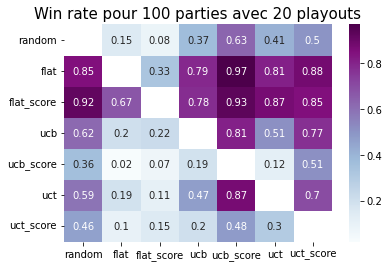

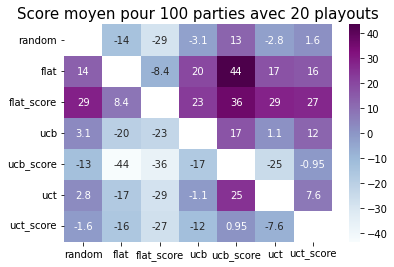

In [58]:
list_strats = ['random', 'flat', 'flat_score', 'ucb', 'ucb_score', 'uct', 'uct_score'] 
plot_tab(res20, dict_mean_scores20, 100, 20, list_strats)

## Comparaisons des stratégies pour 500 playouts (50 parties)

In [42]:
res500 = load_pickle('results500')
res500

,flat,flat_score,ucb,ucb_score,uct
flat,NaN,0.46,0.14,1.0,1.0
flat_score,0.52,NaN,0.18,0.98,1.0
ucb,0.84,0.82,NaN,1.0,1.0
ucb_score,0.0,0.02,0.0,NaN,0.82
uct,0.0,0.0,0.0,0.18,NaN


In [43]:
dict_mean_scores500 = load_pickle('dict_mean_scores500')
dict_mean_scores500

{('flat', 'flat_score'): 6.06,
 ('flat', 'ucb'): -5.6,
 ('flat', 'ucb_score'): 52.22,
 ('flat', 'uct'): 30.76,
 ('flat_score', 'ucb'): -21.78,
 ('flat_score', 'ucb_score'): 63.7,
 ('flat_score', 'uct'): 60.74,
 ('ucb', 'ucb_score'): 51.06,
 ('ucb', 'uct'): 34.04,
 ('ucb_score', 'uct'): 13.2}

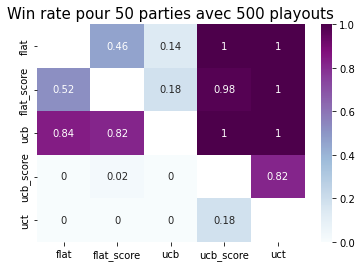

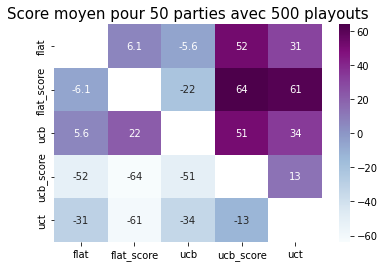

In [59]:
list_strats = ['flat', 'flat_score', 'ucb', 'ucb_score', 'uct'] 
plot_tab(res500, dict_mean_scores500, 50, 500, list_strats)

In [21]:
fig.show()

In [ ]:
print(f"--- {((time.time() - start_time)/60):.2f} minutes ---")